# Multi-Agent Swarm Architecture

In this notebook, we’ll walk through setting up a **multi-agent swarm pattern workflow** in **LangGraph**. Our workflow will consist of three specialized sub-agents connected in a swarm architecture:

* **General QA Agent (RAG)**
* **NL2SQL Agent**
* **Invoice Agent**


Swarm is a Python library for building **swarm-style multi-agent systems** on top of LangGraph. In a swarm, agents dynamically **hand off control** to each other based on their area of expertise. The system also remembers which agent was last active, so that in future interactions, the conversation seamlessly resumes with that same agent.

### Loading environment variables

In [ ]:
### create .env file and store all your private key

# ANTHROPIC_API_KEY="your-anthropic-api-key"
# LANGSMITH_API_KEY="your-langsmith-api-key" # optional
# LANGSMITH_TRACING=True                    # optional
# LANGSMITH_PROJECT="multi-agent-swarm"     # optional

In [ ]:
from dotenv import load_dotenv
# from langchain_openai import ChatOpenAI
# from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain_aws import ChatBedrock
from langchain_anthropic import ChatAnthropic

load_dotenv()

load_dotenv(dotenv_path="../.env", override=True)
# model = ChatOpenAI(model="o3-mini")
# model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
# model = ChatBedrock(model_id="anthropic.claude-3-5-sonnet-20241022-v2:0", region_name="us-west-2", temperature=0)   

# Initialize Anthropic model
model = ChatAnthropic(
    model="claude-3-7-sonnet-latest",  # Claude model ID
    temperature=0,
    # max_tokens=1024
)

### Loading sample customer data

The agent utilizes the [Chinook database](https://www.sqlitetutorial.net/sqlite-sample-database/), which contains sample information on customer information, purchase history, and music catalog. 


##### **1. SQLAlchemy**: A **Python library** for working with databases.
  It’s the *most popular ORM (Object Relational Mapper)* and database toolkit in Python.

* **What it does:**

  * Connects to databases (SQLite, Postgres, MySQL, etc.)
  * Lets you run SQL queries or use Python classes/objects instead of raw SQL.
  * Provides schema inspection, migrations, and query building.

* **Example usage (without LangChain):**

  ```python
  from sqlalchemy import create_engine, text

  engine = create_engine("sqlite:///:memory:")
  with engine.connect() as conn:
      conn.execute(text("CREATE TABLE demo (id INTEGER, name TEXT);"))
      conn.execute(text("INSERT INTO demo VALUES (1, 'Alice');"))
      result = conn.execute(text("SELECT * FROM demo;"))
      print(result.fetchall())
  ```

  👉 **Think of SQLAlchemy as the foundation**: it manages database connections and queries.

---

##### **2. SQLDatabase (LangChain)**

* **What it is:**
  A **LangChain wrapper class** around SQLAlchemy.
  It lives in `langchain_community.utilities.sql_database`.

* **What it does:**

  * Takes an existing SQLAlchemy engine.
  * Exposes helper methods like:

    * `run(sql_query)` → execute queries and return results.
    * `get_table_info()` → get schema details of tables.
    * `get_usable_table_names()` → list usable tables.
  * Makes it easier to connect **LLMs with SQL databases**.

* **Example usage (with LangChain):**

  ```python
  from langchain_community.utilities.sql_database import SQLDatabase
  from sqlalchemy import create_engine

  engine = create_engine("sqlite:///mydb.sqlite")
  db = SQLDatabase(engine)

  print(db.get_usable_table_names())
  print(db.run("SELECT COUNT(*) FROM demo;"))
  ```

  👉 **Think of SQLDatabase as an LLM-friendly wrapper**: it simplifies SQLAlchemy so that language models (via LangChain) can query databases without you writing raw SQL every time.

---

##### Key Difference

* **SQLAlchemy** → General-purpose Python library for working with databases.
* **SQLDatabase (LangChain)** → A specialized wrapper **built on top of SQLAlchemy**, made for use with LLMs in LangChain.



In [3]:
import sqlite3
import requests
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

def get_engine_for_chinook_db():
    """Pull sql file, populate in-memory database, and create engine."""
    # URL of the Chinook sample database schema + data as a SQL script
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql"
    
    # Download the SQL script from GitHub
    response = requests.get(url)
    sql_script = response.text

    # Create an in-memory SQLite database connection
    # check_same_thread=False allows usage across multiple threads
    connection = sqlite3.connect(":memory:", check_same_thread=False)
    
    # Execute the downloaded SQL script to populate the database
    connection.executescript(sql_script)
    
    # Return a SQLAlchemy engine that reuses the same SQLite connection
    # StaticPool ensures the same in-memory DB persists across sessions
    return create_engine(
        "sqlite://",
        creator=lambda: connection,              # reuse existing SQLite connection
        poolclass=StaticPool,                    # keep DB in memory
        connect_args={"check_same_thread": False}, # allow multi-thread access
    )

# Initialize the SQLAlchemy engine with the Chinook dataset
engine = get_engine_for_chinook_db()

# Wrap the engine with LangChain's SQLDatabase utility for natural language querying
db = SQLDatabase(engine)

In [4]:
# See which tables SQLDatabase will use
tables = db.get_usable_table_names()
print("Usable tables for SQLDatabase:", tables)

Usable tables for SQLDatabase: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


In [5]:
# For a single table
print(db.get_table_info(table_names=[tables[0]]))


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


### Setting up short-term memory 

We will also initialize a checkpointer for **short-term memory**, maintaining context within a single thread. 

**Long term memory** lets you store and recall information between conversations. Today, we will utilize our long term memory store to store user preferences for personalization. 



In [6]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore

# Initializing long term memory store 
in_memory_store = InMemoryStore()

# Initializing checkpoint for thread-level memory 
checkpointer = MemorySaver()

### State Management

In [ ]:
from typing_extensions import TypedDict
from typing import Annotated, List
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.managed.is_last_step import RemainingSteps
from typing import Literal


# === STATE DEFINITION ===
class State(TypedDict):
    """Holds the shared state for the multi-agent swarm system."""

    # Unique identifier for the current customer session
    customer_id: str
    
    # Conversation history as a list of messages.
    # Annotated with `add_messages` so new messages are appended (not overwritten).
    messages: Annotated[list[AnyMessage], add_messages]
     
    # Tracks the remaining steps to avoid infinite loops 
    # when executing cyclic graphs in LangGraph.
    remaining_steps: RemainingSteps
    
    # Indicates which agent is currently active in the swarm.
    # This is required by `langgraph_swarm` for proper agent switching.
    active_agent: Literal[
        "general_qa_agent_with_handoff", 
        "nl2sql_agent_with_handoff", 
        "invoice_information_agent_with_handoff"
    ]


## Part 1: Building ReAct Sub-Agents

### 1.1 General Question-Answering Sub-Agents

In [ ]:
from langchain_community.document_loaders import TextLoader
import os
import sqlite3
import requests
from typing import List, Dict, Any, Annotated
from langchain_community.document_loaders import PyPDFLoader, Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
# from langchain_openai import ChatOpenAI
# from langchain_aws import ChatBedrock
from langchain_core.tools import tool

class RAGSystem:
    def __init__(self, folder_path="docs"):
        """
        Initialize the RAG system:
        - folder_path: directory where knowledge documents are stored
        - llm: the language model used for answering queries
        - setup_rag: loads documents, creates embeddings, and initializes vector store
        """
        self.folder_path = folder_path
        # self.llm = ChatBedrock(model_id="anthropic.claude-3-5-sonnet-20241022-v2:0", region_name="us-west-2")
        self.llm = model
        self.setup_rag()  # Initialize RAG components

    def load_documents(self, folder_path):
        """
        Load all .txt files from the folder into LangChain Document objects
        """
        documents = []
        for file in os.listdir(folder_path):
            if file.endswith(".txt"):  # only process .txt files
                loader = TextLoader(os.path.join(folder_path, file))
                documents.extend(loader.load())
        print(f"Loaded {len(documents)} documents.")
        return documents

    def setup_rag(self):
        """
        Sets up the RAG pipeline:
        1. Load documents
        2. Split documents into chunks for better retrieval
        3. Create embeddings for each chunk
        4. Store embeddings in a persistent vector database (Chroma)
        """
        # Load and split documents into smaller chunks
        documents = self.load_documents(self.folder_path)
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,       # each chunk ~1000 characters
            chunk_overlap=200,     # overlapping context to maintain continuity
            length_function=len
        )
        splits = text_splitter.split_documents(documents)
        print(f"Split the documents into {len(splits)} chunks.")

        # Generate vector embeddings for each chunk
        embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

        # Create a Chroma vector store and persist to disk
        collection_name = "rag_collection"
        self.vectorstore = Chroma.from_documents(
            collection_name=collection_name,
            documents=splits,
            embedding=embedding_function,
            persist_directory="./chroma_db_swarm"
        )
        print("Vector store created and persisted.")

        # Configure retriever to get top 3 relevant chunks for a query
        self.retriever = self.vectorstore.as_retriever(search_kwargs={"k": 3})

    def rag_response_generator(self, query: str):
        """
        Generate a response for a query using the RAG pipeline:
        1. Retrieve relevant document chunks
        2. Prepare a system + human prompt with context
        3. Invoke the LLM to get the final answer
        """
        # Retrieve top relevant chunks from vector store
        retrieved_docs = self.retriever.get_relevant_documents(query)
        context = "\n\n".join([doc.page_content for doc in retrieved_docs])

        # Create a prompt template for RAG
        rag_template = ChatPromptTemplate.from_messages([
            ("system", "You are an assistant for question-answering tasks using RAG."),
            ("human", "Query: {question}\n\nContext: {context}")
        ])

        # Chain prompt -> LLM -> output parser
        rag_chain = rag_template | self.llm | StrOutputParser()

        # Invoke the chain with query + retrieved context
        return rag_chain.invoke({
            "question": query,
            "context": context
        })


In [12]:
# Initialize the RAG system pointing to knowledge documents
rag_system = RAGSystem(folder_path="data")

# Define a LangChain tool to expose RAG functionality to agents
@tool
def rag_tool(query: str) -> str:
    """
    Tool for handling general information queries using RAG system
    """
    return rag_system.rag_response_generator(query)

general_qa_tool = [rag_tool]  # Assign tool to variable for agent use

Loaded 1 documents.
Split the documents into 1 chunks.


/tmp/ipykernel_2255/2269391182.py:63: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")


Vector store created and persisted.


In [13]:

general_qa_subagent_prompt = """
    You are a subagent among a team of assistants. 
    You are specialized for general information queries about companies, documents, or knowledge base content that come from the RAG system. 
    
    You have access to one tool: `general_qa_tool`. This tool retrieves relevant context from the knowledge base and generates answers.
    
    IMPORTANT RULES:
    - DO NOT attempt to answer queries about **music albums, artists, tracks, customers, employees, invoices, or any structured database information**. These MUST be handled by the NL2SQL or Invoice agents.
    - If the user asks about anything stored in the database (e.g., "albums by the Rolling Stones", "customer details", "who handled my invoice"), you MUST politely transfer them to the correct agent.
    
    CORE RESPONSIBILITIES:
    - Retrieve and process information from the knowledge base using RAG.
    - Provide clear and accurate answers grounded in the retrieved context.
    - If context is missing, politely say so.
    - Maintain a professional, friendly, and supportive tone.

    """

In [14]:
from langgraph.prebuilt import create_react_agent

# === Define Agent 1: General QA ===
general_qa_subagent = create_react_agent(
    model=model,
    tools = general_qa_tool, 
    prompt = general_qa_subagent_prompt,
    name = "general_qa_agent",
    checkpointer=checkpointer,
)

#### Testing

In [15]:
import uuid
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage

thread_id = uuid.uuid4()
question = "Tell me about the Customer service policies."
config = {"configurable": {"thread_id": thread_id}}

result = general_qa_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

/tmp/ipykernel_2255/2269391182.py:86: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = self.retriever.get_relevant_documents(query)


================================ Human Message =================================

Tell me about the Customer service policies.
================================== Ai Message ==================================
Name: general_qa_agent

I'll help you find information about the customer service policies by querying our knowledge base.
Tool Calls:
  rag_tool (toolu_bdrk_01KRBnB6fX6QqZmg1PVs3N68)
 Call ID: toolu_bdrk_01KRBnB6fX6QqZmg1PVs3N68
  Args:
    query: What are the customer service policies?
================================= Tool Message =================================
Name: rag_tool

Based on the provided context, here are the customer service policies for Acme Music Inc.:

1. Refunds: Customers can get refunds within 7 days of purchase.

2. VIP Member Benefits: VIP members receive a 20% discount on all albums.

3. Technical Support: Support is available 24/7 through both email and phone channels.

These policies demonstrate the company's commitment to customer satisfaction and supp

### 1.2 Nl2SQL

In [16]:
# Import necessary libraries for SQL database interaction and LangChain functionality
from langchain_community.utilities.sql_database import SQLDatabase
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from operator import itemgetter
import re

class NL2SQLSystem:
    """Natural Language to SQL conversion system using LangChain and Claude"""
    
    def __init__(self):
        # Initialize database connection using Chinook sample database
        self.engine = get_engine_for_chinook_db()
        
        # Create SQLDatabase wrapper for LangChain integration
        self.db = SQLDatabase(self.engine)
        
        # Initialize Claude 3.5 Sonnet model via AWS Bedrock
        self.llm = ChatBedrock(
            model_id="anthropic.claude-3-5-sonnet-20241022-v2:0",
            region_name="us-west-2"
        )
        
        # Create tool for executing SQL queries on the database
        self.sql_tool = QuerySQLDataBaseTool(db=self.db)
    
    def clean_sql_query(self, markdown_query: str) -> str:
        """
        Clean LLM-generated SQL by removing markdown formatting and extra characters
        Args: markdown_query - Raw SQL query response from LLM (may contain ```sql blocks)
        Returns: Clean SQL query string ready for execution
        """
        # Split query into individual lines for processing
        lines = markdown_query.strip().split('\n')
        cleaned_lines = []
        
        # Remove markdown code fence lines (```sql, ```, etc.)
        for line in lines:
            if line.strip().startswith('```') or line.strip().lower() == 'sql':
                continue  # Skip markdown formatting lines
            cleaned_lines.append(line)
        
        # Join cleaned lines and remove backticks
        cleaned_query = ' '.join(cleaned_lines).strip()
        cleaned_query = cleaned_query.replace('`', '')  # Remove any remaining backticks
        
        return cleaned_query
    
    def sql_response_generator(self, question: str):
        """
        Main method: Convert natural language question to SQL and execute it
        Args: question - User's natural language query
        Returns: Database query results
        """
        
        # Get database schema information for context
        schema = self.db.get_table_info()
        print("\n[DEBUG] Schema provided to LLM:\n", schema)
        
        # Create prompt template with system instructions and schema context
        sql_prompt = ChatPromptTemplate.from_messages([
            ("system",
             "You are a SQLite expert. Given an input question, create a syntactically correct SQL query. "
             "Use the exact table names and column names from the schema below:\n\n{table_info}\n\n"
             "Do not add explanations or semicolons. Only return the SQL query."
             ),
            ("human", "{input}")  # User's natural language question
        ])
        
        # Create processing chain: prompt → LLM → string output
        sql_chain = sql_prompt | self.llm | StrOutputParser()
        
        # Generate SQL query by invoking the chain with question and schema
        raw_query = sql_chain.invoke({
            "input": question,
            "table_info": schema
        })
        
        # Clean the generated query (remove markdown formatting)
        cleaned_query = self.clean_sql_query(raw_query)
        
        # Debug output to track the conversion process
        print(f"\n[DEBUG] Raw query from LLM:\n{raw_query}")
        print(f"[DEBUG] Cleaned query:\n{cleaned_query}")
        
        # Execute the cleaned SQL query on the database
        result = self.sql_tool.run(cleaned_query)
        print(f"[DEBUG] Query result: {result}\n")
        
        return result


/tmp/ipykernel_2255/2295725587.py:25: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  self.sql_tool = QuerySQLDataBaseTool(db=self.db)


In [ ]:
# Create global instance of the NL2SQL system
nl2sql_system = NL2SQLSystem()

@tool
def sql_tool(query: str) -> str:
    """
    LangChain tool wrapper for the NL2SQL system
    Args: query - Natural language database question
    Returns: Formatted query results as string
    """
    return nl2sql_system.sql_response_generator(query)

# Create tool instance for use in LangChain agents/chains
nl2sql_tool = [sql_tool]

In [17]:
nl2sql_subagent_prompt = """
    You are a subagent among a team of assistants. 
    You are specialized for database-related queries that require converting natural language questions into SQL queries. 
    
    You have access to one tool: `nl2sql_tool`. This tool generates SQL queries and runs them on the database.
    
    IMPORTANT RULES:
    - You MUST handle all queries involving **albums, artists, tracks, customers, employees, or other structured information stored in the database**.
    - DO NOT delegate these to the General QA (RAG) agent. Only you can answer them correctly.
    - Only if the query is clearly about company policies, services, or knowledge base documents (not database entities), you may allow transfer to General QA.
    
    CORE RESPONSIBILITIES:
    - Translate natural language questions into correct SQL queries.
    - Execute the queries and present results in a clear, user-friendly way.
    - Avoid raw SQL unless explicitly asked.
    - Maintain a professional, patient, and helpful tone.

    """



In [18]:
# === Define Agent 2: nl2sql ===
nl2sql_qa_subagent = create_react_agent(
    model=model,
    tools = nl2sql_tool, 
    prompt = nl2sql_subagent_prompt,
    name = "nl2sql_qa_subagent",
    checkpointer=checkpointer,
)

#### Testing

In [19]:
import uuid
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage

thread_id = uuid.uuid4()
question = "Do you have any albums by the Rolling Stones?"
config = {"configurable": {"thread_id": thread_id}}

result = nl2sql_qa_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()


[DEBUG] Schema provided to LLM:
 
CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId"), 
	FOREIGN KE

### 1.3 Invoice Tool

In [20]:
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

@tool 
def get_invoices_by_customer_sorted_by_date(customer_id: str) -> list[dict]:
    """
    Look up all invoices for a customer using their ID.
    The invoices are sorted in descending order by invoice date, which helps when the customer wants to view their most recent/oldest invoice, or if 
    they want to view invoices within a specific date range.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices for the customer.
    """
    return db.run(f"SELECT * FROM Invoice WHERE CustomerId = {customer_id} ORDER BY InvoiceDate DESC;")


@tool 
def get_invoices_sorted_by_unit_price(customer_id: str) -> list[dict]:
    """
    Use this tool when the customer wants to know the details of one of their invoices based on the unit price/cost of the invoice.
    This tool looks up all invoices for a customer, and sorts the unit price from highest to lowest. In order to find the invoice associated with the customer, 
    we need to know the customer ID.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices sorted by unit price.
    """
    query = f"""
        SELECT Invoice.*, InvoiceLine.UnitPrice
        FROM Invoice
        JOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId
        WHERE Invoice.CustomerId = {customer_id}
        ORDER BY InvoiceLine.UnitPrice DESC;
    """
    return db.run(query)


@tool
def get_employee_by_invoice_and_customer(invoice_id: str, customer_id: str) -> dict:
    """
    This tool will take in an invoice ID and a customer ID and return the employee information associated with the invoice.

    Args:
        invoice_id (int): The ID of the specific invoice.
        customer_id (str): customer_id, which serves as the identifier.

    Returns:
        dict: Information about the employee associated with the invoice.
    """

    query = f"""
        SELECT Employee.FirstName, Employee.Title, Employee.Email
        FROM Employee
        JOIN Customer ON Customer.SupportRepId = Employee.EmployeeId
        JOIN Invoice ON Invoice.CustomerId = Customer.CustomerId
        WHERE Invoice.InvoiceId = ({invoice_id}) AND Invoice.CustomerId = ({customer_id});
    """
    
    employee_info = db.run(query, include_columns=True)
    
    if not employee_info:
        return f"No employee found for invoice ID {invoice_id} and customer identifier {customer_id}."
    return employee_info

invoice_tools = [get_invoices_by_customer_sorted_by_date, get_invoices_sorted_by_unit_price, get_employee_by_invoice_and_customer]

In [21]:
invoice_subagent_prompt = """
    You are a subagent among a team of assistants. You are specialized for retrieving and processing invoice information. You are routed for invoice-related portion of the questions, so only respond to them.. 

    You have access to three tools. These tools enable you to retrieve and process invoice information from the database. Here are the tools:
    - get_invoices_by_customer_sorted_by_date: This tool retrieves all invoices for a customer, sorted by invoice date.
    - get_invoices_sorted_by_unit_price: This tool retrieves all invoices for a customer, sorted by unit price.
    - get_employee_by_invoice_and_customer: This tool retrieves the employee information associated with an invoice and a customer.
    
    If you are unable to retrieve the invoice information, inform the customer you are unable to retrieve the information, and ask if they would like to search for something else.
    
    CORE RESPONSIBILITIES:
    - Retrieve and process invoice information from the database
    - Provide detailed information about invoices, including customer details, invoice dates, total amounts, employees associated with the invoice, etc. when the customer asks for it.
    - Always maintain a professional, friendly, and patient demeanor
    
    You may have additional context that you should use to help answer the customer's query. It will be provided to you below:
    """

In [34]:
# === Define Agent 3: invoice information ===
invoice_information_subagent = create_react_agent(
    model=model,
    tools = invoice_tools, 
    prompt = invoice_subagent_prompt,
    name = "invoice_information_agent",
    checkpointer=checkpointer,
    state_schema=State
)

#### Testing

In [35]:
import uuid
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage

thread_id = uuid.uuid4()
question = "What was my most recent invoice, and who was the employee that helped me with it?"
config = {"configurable": {"thread_id": thread_id}}

result = invoice_information_subagent.invoke({"messages": [HumanMessage(content=question)], "customer_id": 1}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What was my most recent invoice, and who was the employee that helped me with it?
================================== Ai Message ==================================
Name: invoice_information_agent

I apologize, but I notice that I need your customer ID to look up your invoice information. Could you please provide your customer ID? Once you share that, I'll be able to:
1. Find your most recent invoice
2. Look up the employee who assisted you with that invoice

This information will help me provide you with accurate details about your most recent invoice and the associated employee.


In [24]:
thread_id = uuid.uuid4()
question = "My customer id is 2. What was my most recent invoice, and who was the employee that helped me with it?"
config = {"configurable": {"thread_id": thread_id}}

result = invoice_information_subagent.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

My customer id is 2. What was my most recent invoice, and who was the employee that helped me with it?
================================== Ai Message ==================================
Name: invoice_information_agent

I'll help you find your most recent invoice and the employee associated with it. Let me retrieve this information for you.

First, I'll get your invoices sorted by date:
Tool Calls:
  get_invoices_by_customer_sorted_by_date (toolu_bdrk_01FrsCLkkFaWTmjsNM2bcfsm)
 Call ID: toolu_bdrk_01FrsCLkkFaWTmjsNM2bcfsm
  Args:
    customer_id: 2
================================= Tool Message =================================
Name: get_invoices_by_customer_sorted_by_date

[(293, 2, '2024-07-13 00:00:00', 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', 0.99), (241, 2, '2023-11-23 00:00:00', 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', 5.94), (219, 2, '2023-08-21 00:00:

## Building multi-agent architecture (Swarm)

Now that we have three specialized sub-agents: one for General QA inquiries, a second for Natural Language to SQL query and a third one specially for invoice information. The next logical step is to ensure that customer queries are routed to the appropriate agent. This is where a Swarm agent comes into play.

In [ ]:
from langgraph_swarm import create_handoff_tool, create_swarm
from langgraph.prebuilt import create_react_agent

# === Define Agent 1: General QA ===
# Create the primary agent that handles general queries and acts as a router/coordinator
general_qa_agent_with_handoff = create_react_agent(
    model=model,
    tools=[
        *general_qa_tool,
        create_handoff_tool(agent_name="invoice_information_agent_with_handoff", description = "Transfer user to the invoice information agent that can help with invoice information"),
        create_handoff_tool(agent_name="nl2sql_agent_with_handoff", description = "Transfer user to the nl2sql agent that can help with database related queries"),
    ],
    name="general_qa_agent_with_handoff",
    prompt = general_qa_subagent_prompt,
    state_schema=State
)


# === Define Agent 2: nl2sql ===
# Specialized agent for converting natural language to SQL and querying databases
nl2sql_agent_with_handoff = create_react_agent(
    model=model,
    tools=[
        *nl2sql_tool,
        create_handoff_tool(agent_name="general_qa_agent_with_handoff", description = "Transfer user to the general qa agent that can help with general information queries about companies, documents, or knowledge base content"),
        create_handoff_tool(agent_name="invoice_information_agent_with_handoff", description = "Transfer user to the invoice information agent that can help with invoice information"),
    ],
    name="nl2sql_agent_with_handoff",
    prompt = nl2sql_subagent_prompt,
    state_schema=State
)


# === Define Agent 3: invoice information ===
# Dedicated agent for handling all invoice, billing, and payment-related queries
invoice_information_agent_with_handoff = create_react_agent(
    model=model,
    tools=[
        *invoice_tools,  # Unpack the list so individual tools are passed
        create_handoff_tool(agent_name="general_qa_agent_with_handoff", description = "Transfer user to the general qa agent that can help with general information queries about companies, documents, or knowledge base content"),
        create_handoff_tool(agent_name="nl2sql_agent_with_handoff", description = "Transfer user to the nl2sql agent that can help with database related queries"),
    ],
    prompt = invoice_subagent_prompt,
    name = "invoice_information_agent_with_handoff",
    state_schema=State
)


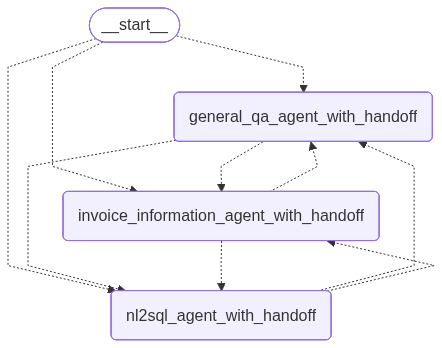

In [ ]:
swarm_workflow = create_swarm(
    agents = [general_qa_agent_with_handoff, nl2sql_agent_with_handoff, invoice_information_agent_with_handoff],
    default_active_agent = "general_qa_agent_with_handoff",
    state_schema=State
)

# Compile with checkpointer/store
swarm_agents = swarm_workflow.compile(
    checkpointer = checkpointer, 
    # state_schema=State
    # store = in_memory_store
)


from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        swarm_agents.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Testing

In [54]:
import uuid
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage

# Create a new thread
thread_id = uuid.uuid4()

question = "Do you have any albums by the Rolling Stones?"
config = {"configurable": {"thread_id": thread_id}}

# Invoke the swarm agents. The default active agent will hand off to our music catalog agent instead of trying to solve the problem itself
result = swarm_agents.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()


[DEBUG] Schema provided to LLM:
 
CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId"), 
	FOREIGN KE

In [55]:
thread_id = uuid.uuid4()
question = "My customer id is 1. What was my most recent invoice, and who was the employee that helped me with it?"
config = {"configurable": {"thread_id": thread_id}}

# Invoke the swarm agents. The default active agent will hand off to our music catalog agent instead of trying to solve the problem itself
result = swarm_agents.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

My customer id is 1. What was my most recent invoice, and who was the employee that helped me with it?
================================== Ai Message ==================================
Name: general_qa_agent_with_handoff

I notice that you're asking about invoice and employee information, which is stored in the database. I'll need to transfer you to the appropriate agent who can help you with invoice-related queries.
Tool Calls:
  transfer_to_invoice_information_agent_with_handoff (toolu_bdrk_015oXXKjuudJHctNTYnD9b2v)
 Call ID: toolu_bdrk_015oXXKjuudJHctNTYnD9b2v
  Args:
================================= Tool Message =================================
Name: transfer_to_invoice_information_agent_with_handoff

Successfully transferred to invoice_information_agent_with_handoff
================================== Ai Message ==================================
Name: invoice_information_agent_with_handoff

I'll hel

In [56]:
thread_id = uuid.uuid4()
question = "Tell me about the company location."
config = {"configurable": {"thread_id": thread_id}}

# Invoke the swarm agents. The default active agent will hand off to our music catalog agent instead of trying to solve the problem itself
result = swarm_agents.invoke({"messages": [HumanMessage(content=question)]}, config=config)
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Tell me about the company location.
================================== Ai Message ==================================
Name: general_qa_agent_with_handoff

I'll help you find information about the company's location using the RAG tool.
Tool Calls:
  rag_tool (toolu_bdrk_01B2kAyRsChq1CqPnj24Pw4g)
 Call ID: toolu_bdrk_01B2kAyRsChq1CqPnj24Pw4g
  Args:
    query: What is the company's location and address?
================================= Tool Message =================================
Name: rag_tool

Based on the provided context, the company's offices are located in Seattle, WA. The company also has remote teams working globally. However, the specific street address is not mentioned in the given context.
================================== Ai Message ==================================
Name: general_qa_agent_with_handoff

Based on the available information, the company is located in Seattle, Washington. While t

## Multi-Turn Conversation

In [33]:
# Simple Multi-Turn Chat Interface for Jupyter Notebook
import uuid
from langchain_core.messages import HumanMessage

def start_chat():
    """Simple chat interface for multi-agent swarm"""
    print("🤖 Multi-Agent Chat Started (type 'quit' to exit)")
    print("Available: General QA | NL2SQL | Invoice agents")
    print("-" * 50)
    
    # Create new thread for conversation
    thread_id = str(uuid.uuid4())
    config = {"configurable": {"thread_id": thread_id}}
    
    while True:
        # Get user input
        user_input = input("\n👤 You: ").strip()
        
        # Exit conditions
        if user_input.lower() in ['quit', 'exit', 'bye', 'q']:
            print("👋 Chat ended!")
            break
            
        if not user_input:
            continue
            
        try:
            # Process with swarm agents
            print("🔄 Processing...")
            result = swarm_agents.invoke(
                {"messages": [HumanMessage(content=user_input)]}, 
                config=config
            )
            
            # Get final AI response
            ai_messages = [msg for msg in result["messages"] 
                          if hasattr(msg, 'name') and msg.name]
            
            if ai_messages:
                final_msg = ai_messages[-1]
                print(f"\n🤖 {final_msg.name}:")
                print(f"{final_msg.content}")
                
                # Show agent handoffs if any
                if len(ai_messages) > 1:
                    agents_used = [msg.name for msg in ai_messages]
                    print(f"\n🔄 Agent flow: {' → '.join(agents_used)}")
            else:
                print("❌ No response received")
                
        except Exception as e:
            print(f"❌ Error: {str(e)}")
            print("Please try again or type 'quit' to exit")

# Run the chat
start_chat()

🤖 Multi-Agent Chat Started (type 'quit' to exit)
Available: General QA | NL2SQL | Invoice agents
--------------------------------------------------



👤 You:  my customer id is 1, tell me my famous album.


🔄 Processing...

[DEBUG] Schema provided to LLM:
 
CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId


👤 You:  what is my customer id?


🔄 Processing...

[DEBUG] Schema provided to LLM:
 
CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId


👤 You:  quit


👋 Chat ended!
